# Per capita electricity generation of EU countries and the UK

This notebooks details the data preparation and plotting of chart showing electricity generation per capita of EU countries and the United Kingdom.

## Load prerequisities

This notebooks uses the Tidyverse libraries and the `readxl` package. To install these libraries, run the command `install.packages(c("readxl", "tidyverse"))` in your R instance.

In [ ]:
library(tidyverse)
library(readxl)

## Electricity generation data

For this visualization, we use the electricity generation data from the [Ember yearly electricity dataset](https://ember-climate.org/data-catalogue/yearly-electricity-data/). The "Yearly Full Release Long Format" CSV file was downloaded into `/data/ember/yearly_full_release_long_format.csv`. The dataset is described as follows:

> The dataset contains yearly electricity generation, capacity, emissions, import and demand data for over 200 geographies. Data is collected from multi-country datasets (EIA, Eurostat, BP, UN) as well as national sources (e.g China data from the National Bureau of Statistics).

As we will need only electricity generation data for our analysis, and we will examine only the EU countries and the UK, we first need to filter the dataset accordingly. For the purpose of the visualization, we will also add two new columns: ValuekWh and GenerationCategory.

In [ ]:
DATASET_PATH_ELECTRICITY <- "../data/ember/yearly_full_release_long_format.csv"

electricity_eu28 <- DATASET_PATH_ELECTRICITY |>
  read_csv(# Select only columns relevant for our analysis.          
           col_select = c("Country code", "Year", "Category", "Variable", "Value", "Unit", "EU"),
           show_col_types = FALSE) |>
  # Filter EU countries and UK (= GBR), electricity generation and demand category, and TWh unit.
  filter(EU == 1 | `Country code` == "GBR",
         Category %in% c("Electricity generation", "Electricity demand"),
         Unit == "TWh") |>
  select(CountryCode = "Country code",
         Year = "Year",
         Variable = "Variable",
         ValueTWh = "Value") |>
  mutate(ValuekWh = ValueTWh * 1000000000,
         GenerationCategory = case_when(Variable == "Coal" ~ "Coal",
                                  Variable %in% c("Gas", "Other Fossil") ~ "Other Fossil Fuels",
                                  Variable %in% c("Wind", "Solar", "Hydro", "Bioenergy") ~ "Renewables",
                                  Variable == "Nuclear" ~ "Nuclear",
                                  Variable == "Demand" ~ "Demand")) |>
  filter(GenerationCategory != "NA") |>
  select(-Variable) |>
  group_by(CountryCode, Year, GenerationCategory) |>
  summarise(ValuekWh = sum(ValuekWh))

We now have the table of annual electricity generation per country and energy source category in a long format:

In [11]:
head(electricity_eu28)

CountryCode,Year,GenerationCategory,ValuekWh
<chr>,<dbl>,<chr>,<dbl>
AUT,2000,Coal,5.720e+09
AUT,2000,Demand,5.827e+10
AUT,2000,Nuclear,0.000e+00
AUT,2000,Other Fossil Fuels,1.048e+10
AUT,2000,Renewables,4.344e+10
AUT,2001,Coal,6.890e+09


## Population data

As we want to visualize electricity generation trends per capita, we also use the population data from the [UN demographic indicators dataset](https://population.un.org/wpp/). The "Compact (most used: estimates and medium projections)" XLSX file was downloaded into `/data/un/WPP2024_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT.xlsx`. The dataset is described as follows:

> The dataset contains yearly population estimates and projections that have been prepared by the Population Division of the Department of Economic and Social Affairs of the United Nations Secretariat. It presents population estimates from 1950 to the present for 237 countries or areas.

As we will need only need countries’ pouplation data in a period of 2000–2023 for our analysis, we first need to tidy and filter the dataset accordingly.

In [6]:
DATASET_PATH_POPULATION <- "../data/un/WPP2024_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT.xlsx"

population <- read_xlsx(# Read a sheet relevant for our analysis and skip excessive heading.
                        DATASET_PATH_POPULATION, sheet = "Estimates", skip = 16,
                        col_types = "text") |>
  select(# Select only columns relevant for our analysis.
         Country = 3,
         CountryCode = 6,
         Year = 11,
         Population = 12) |>
  mutate(# As the population data in the dataset is depicted in thousands, multiply it by 1000.
         Population = as.numeric(Population)*1000,
         Year = as.double(Year)) |>
  filter(Year %in% c(2000:2023))

Warning message:
"There was 1 warning in `mutate()`.
i In argument: `Population = as.numeric(Population) * 1000`.
Caused by warning:
! NAs introduced by coercion"


We now have the table of annual population per country in a long format:

In [18]:
head(population)

Country,CountryCode,Year,Population
<chr>,<chr>,<dbl>,<dbl>
World,NA,2000,6129943964
World,NA,2001,6213462023
World,NA,2002,6296410896
World,NA,2003,6379049788
World,NA,2004,6461673479
World,NA,2005,6545082065


## Data wrangling

Now, we will join the electricity generation and population datasets together and add a new column containing electricity generation per capita.

In [7]:
# Join the datasets and reorder generation category.
electricity_population_eu28 <- left_join(electricity_eu28, population, by = c("CountryCode", "Year")) |>
  mutate(ValuekWhPerCapita = (ValuekWh / Population),
         GenerationCategory = factor(GenerationCategory, levels = c("Renewables", "Nuclear", "Other Fossil Fuels", "Coal", "Demand")))

head(electricity_population_eu28)

CountryCode,Year,GenerationCategory,ValuekWh,Country,Population,ValuekWhPerCapita
<chr>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<dbl>
AUT,2000,Coal,5.720e+09,Austria,8003663,714.6728
AUT,2000,Demand,5.827e+10,Austria,8003663,7280.4165
AUT,2000,Nuclear,0.000e+00,Austria,8003663,0.0000
AUT,2000,Other Fossil Fuels,1.048e+10,Austria,8003663,1309.4005
AUT,2000,Renewables,4.344e+10,Austria,8003663,5427.5149
AUT,2001,Coal,6.890e+09,Austria,8022193,858.8674


It will be convenient to also include EU-27 total electricity generation per capita and year and per energy source category, therefore, we will add it into the data frame.

In [ ]:
electricity_population_eu27_total <- electricity_population_eu28 |>
  group_by(Year, GenerationCategory) |>
  summarise(ValuekWh = sum(ValuekWh),
            Population = sum(Population)) |>
  mutate(CountryCode = "EU27",
         .before=Year) |>
  mutate(ValuekWhPerCapita = (ValuekWh / Population),
         .after=Population) |>
  mutate(Country = case_when(CountryCode == "EU27" ~ "EU-27"))

head(electricity_population_eu27_total)

In [14]:
# Append the total to the existing dataframe.
electricity_population_eu28_incl_eu27_total <- rbind(electricity_population_eu28, electricity_population_eu27_total) |>
  select(# Select only columns relevant for our analysis.
         -ValuekWh,
         -Population) |>
  mutate(# Add a column with country names in Czech.
         Country_cs = case_when(CountryCode == "AUT" ~ "Rakousko",
                                 CountryCode == "BEL" ~ "Belgie",
                                 CountryCode == "BGR" ~ "Bulharsko",
                                 CountryCode == "CYP" ~ "Kypr",
                                 CountryCode == "CZE" ~ "Česká republika",
                                 CountryCode == "DEU" ~ "Německo",
                                 CountryCode == "DNK" ~ "Dánsko",
                                 CountryCode == "ESP" ~ "Španělsko",
                                 CountryCode == "EST" ~ "Estonsko",
                                 CountryCode == "FIN" ~ "Finsko",
                                 CountryCode == "FRA" ~ "Francie",
                                 CountryCode == "GRC" ~ "Řecko",
                                 CountryCode == "HRV" ~ "Chorvatsko",
                                 CountryCode == "HUN" ~ "Maďarsko",
                                 CountryCode == "IRL" ~ "Irsko",
                                 CountryCode == "ITA" ~ "Itálie",
                                 CountryCode == "LTU" ~ "Litva",
                                 CountryCode == "LUX" ~ "Lucembursko",
                                 CountryCode == "LVA" ~ "Lotyšsko",
                                 CountryCode == "MLT" ~ "Malta",
                                 CountryCode == "NLD" ~ "Nizozemsko",
                                 CountryCode == "POL" ~ "Polsko",
                                 CountryCode == "PRT" ~ "Portugalsko",
                                 CountryCode == "ROU" ~ "Rumunsko",
                                 CountryCode == "SVK" ~ "Slovensko",
                                 CountryCode == "SVN" ~ "Slovinsko",
                                 CountryCode == "SWE" ~ "Švédsko",
                                 CountryCode == "EU27" ~ "Evropská unie",
                                 CountryCode == "GBR" ~ "Velká Británie" ))
         
head(electricity_population_eu28_incl_eu27_total)

CountryCode,Year,GenerationCategory,Country,ValuekWhPerCapita,Country_cs
<chr>,<dbl>,<fct>,<chr>,<dbl>,<chr>
AUT,2000,Coal,Austria,714.6728,Rakousko
AUT,2000,Demand,Austria,7280.4165,Rakousko
AUT,2000,Nuclear,Austria,0.0000,Rakousko
AUT,2000,Other Fossil Fuels,Austria,1309.4005,Rakousko
AUT,2000,Renewables,Austria,5427.5149,Rakousko
AUT,2001,Coal,Austria,858.8674,Rakousko


## Generating small multiples

We will now plot line charts for each country in the EU and the UK depicting electricity generation per capita and per energy source in a period of 2000–2023. We will do so in a single infographic, a visualization type commonly known as *small multiples*.

In [25]:
# Generate a chart with English annotations.
ggplot(filter(electricity_population_eu28_incl_eu27_total, GenerationCategory != "Demand"), aes(x = Year, y = ValuekWhPerCapita)) +
  geom_area(aes(fill = GenerationCategory)) +
  facet_wrap(vars(Country), nrow = 5, ncol = 7) +
  scale_fill_manual(values = c('Coal' = '#eb4a66',
                               'Other Fossil Fuels' = '#b33370',
                               'Nuclear' = '#8195a6',
                               'Renewables' = '#33b8ad')) +
  geom_line(data = filter(electricity_population_eu28_incl_eu27_total, GenerationCategory == "Demand")) +
  theme_minimal() +
  theme(panel.grid.minor = element_blank(),
        panel.background = element_rect(fill = "#f0f0f0", color = "#f0f0f0")) +
  geom_col(data = filter(electricity_population_eu28_incl_eu27_total, Year %in% c("2010", "2020"), GenerationCategory != "Demand"), aes(x = Year, y = ValuekWhPerCapita),
           width = 0.1, fill = "black") +
  scale_x_continuous(breaks = c(2000, 2010, 2021), expand = c(0,0)) +
  scale_y_continuous(breaks = c(5000, 10000, 15000), expand = c(0,0)) +
  labs(x = "Year",
       y = "Electricity production per capita [kWh]",
       title = "Electricity production per capita in the EU and the UK")



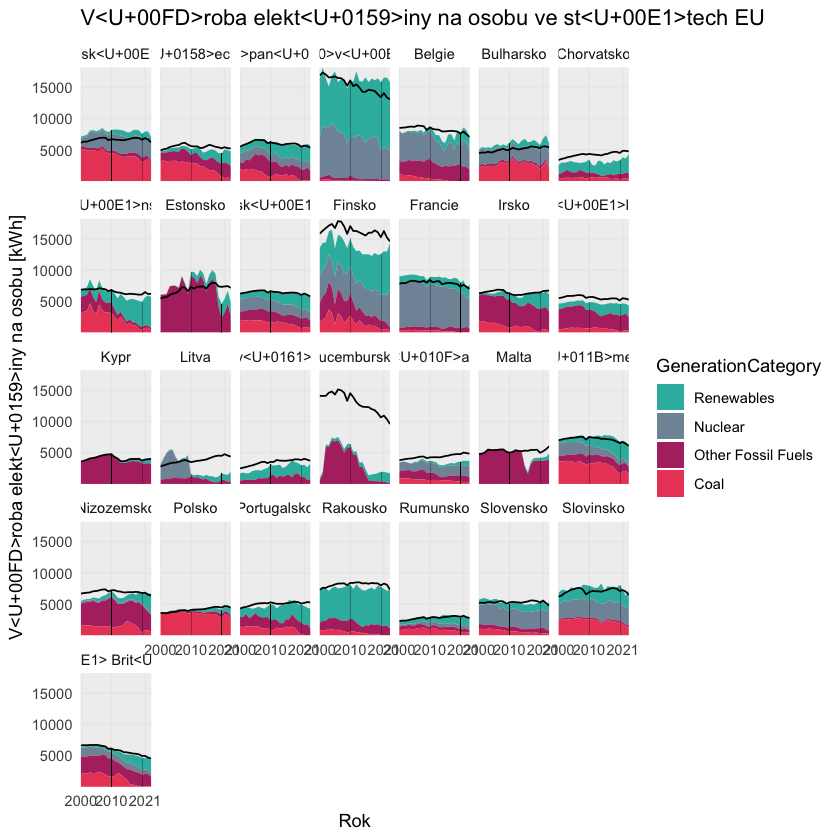

In [26]:
# Generate a chart with Czech annotations.
ggplot(filter(electricity_population_eu28_incl_eu27_total, GenerationCategory != "Demand"), aes(x = Year, y = ValuekWhPerCapita)) +
  geom_area(aes(fill = GenerationCategory)) +
  facet_wrap(vars(Country_cs), nrow = 5, ncol = 7) +
  scale_fill_manual(values = c('Coal' = '#eb4a66',
                               'Other Fossil Fuels' = '#b33370',
                               'Nuclear' = '#8195a6',
                               'Renewables' = '#33b8ad')) +
  geom_line(data = filter(electricity_population_eu28_incl_eu27_total, GenerationCategory == "Demand")) +
  theme_minimal() +
  theme(panel.grid.minor = element_blank(),
        panel.background = element_rect(fill = "#f0f0f0", color = "#f0f0f0")) +
  geom_col(data = filter(electricity_population_eu28_incl_eu27_total, Year %in% c("2010", "2020"), GenerationCategory != "Demand"), aes(x = Year, y = ValuekWhPerCapita),
           width = 0.1, fill = "black") +
  scale_x_continuous(breaks = c(2000, 2010, 2021), expand = c(0,0)) +
  scale_y_continuous(breaks = c(5000, 10000, 15000), expand = c(0,0)) +
  labs(x = "Rok",
       y = "Výroba elektřiny na osobu [kWh]",
       title = "Výroba elektřiny na osobu ve státech EU")

In [27]:
# Save plot in an svg file.
ggsave("per-capita-electricity-eu.svg", width = 26.7, height = 16.7)